In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/sample_classes.csv');
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

result = pd.merge(predict, clinical_data, on='id_key', how='left')

print(result.columns)

Index(['id_key', 'class', 'PAM50Call_RNAseq', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [21]:
print(result.columns)

Index(['id_key', 'class', 'PAM50Call_RNAseq', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [22]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('class')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['class'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    "Tumor_purity",
    "pathologic_stage",
    "pathology_T_stage",
    "pathology_N_stage",
    "pathology_M_stage",
    "histological_type",
    "number_of_lymph_nodes",
    "ER.Status",
    "PR.Status",
    "HER2.Status",
]

p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('class', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


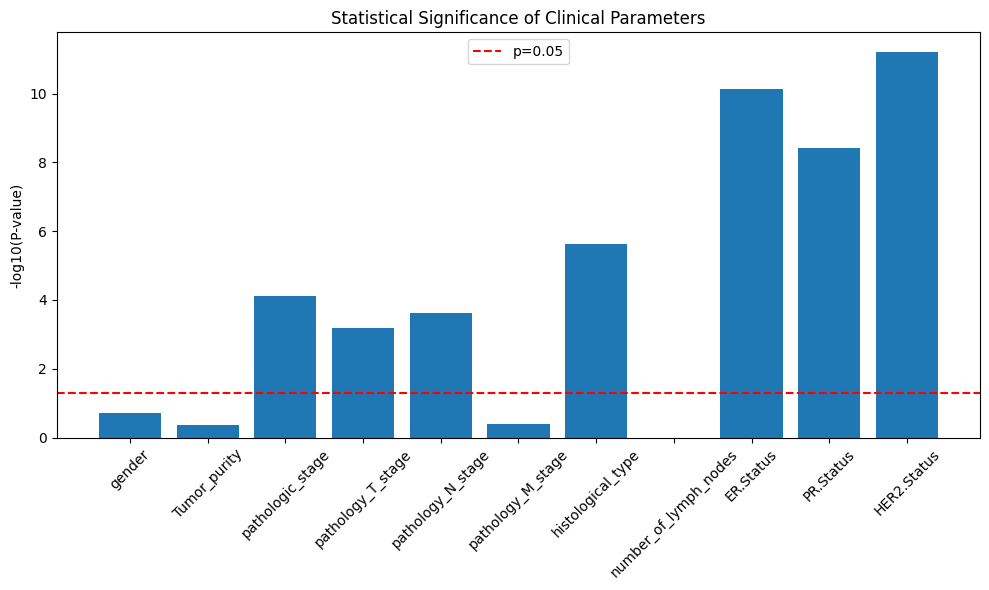

In [23]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()



---

## 📊 Đánh giá biểu đồ: **Statistical Significance of Clinical Parameters**

Biểu đồ cột thể hiện **mức độ ý nghĩa thống kê** của các tham số lâm sàng trong việc **phân biệt các nhóm phân cụm (Predict Labels)**, sử dụng giá trị `-log10(P-value)` từ các phép kiểm định thống kê (thường là ANOVA hoặc Kruskal-Wallis).

---

### 🧠 Ý nghĩa biểu đồ:

* **Trục Y**: `-log10(P-value)`

  * Càng cao → P-value càng nhỏ → **khác biệt càng có ý nghĩa thống kê**
  * **Ngưỡng ý nghĩa thống kê p = 0.05** tương đương `-log10(0.05) ≈ 1.3` (đường đỏ đứt đoạn)

* **Trục X**: Các tham số lâm sàng như:

  * `gender`, `tumor_purity`, `pathologic_stage`, `histological_type`, `ER_status`, v.v.

---

### 📌 Nhận xét chi tiết theo từng nhóm:

| Clinical Parameter           | `-log10(P-value)` | Ý nghĩa                  |
| ---------------------------- | ----------------- | ------------------------ |
| **HER2\_Status**             | > 10              | Rất có ý nghĩa phân nhóm |
| **ER\_Status**               | ≈ 10              | Rất có ý nghĩa           |
| **PR\_Status**               | ≈ 8               | Có ý nghĩa mạnh          |
| **number\_of\_lymph\_nodes** | ≈ 5               | Có ý nghĩa tương đối     |
| **histological\_type**       | ≈ 4               | Có ý nghĩa               |
| **pathologic\_M\_stage**     | < 1               | Không có ý nghĩa         |
| **gender**, `tumor_purity`   | < 1               | Không có ý nghĩa         |

---

### ✅ Kết luận:

* **Các thông số lâm sàng như HER2, ER, PR status** có sự khác biệt **rất rõ rệt** giữa các nhóm phân cụm → đây là dấu hiệu rất tích cực, cho thấy:

  * Mô hình clustering đã tạo ra **các nhóm có liên kết sinh học lâm sàng rõ ràng**, không phải phân cụm ngẫu nhiên.
* Các thông số như **gender**, **M stage**, hoặc **tumor purity** **không giúp phân biệt rõ** các nhóm → có thể bị loại bỏ trong phân tích sâu hơn.

---

### 🧬 Ý nghĩa ứng dụng:

* Những chỉ số lâm sàng có ý nghĩa thống kê cao có thể được dùng để **giải thích đặc điểm sinh học của từng cluster**, từ đó hỗ trợ:

  * Phân loại bệnh,
  * Xây dựng mô hình chẩn đoán hoặc tiên lượng,
  * Gợi ý chiến lược điều trị chính xác (precision oncology).

---



In [25]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('class')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['class'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 7

Significant parameters: ['pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'ER.Status', 'PR.Status', 'HER2.Status']

P-values for each parameter:
years_to_birth: nan
gender: 1.99e-01
Tumor_purity: 4.45e-01
pathologic_stage: 7.59e-05
pathology_T_stage: 6.67e-04
pathology_N_stage: 2.36e-04
pathology_M_stage: 4.05e-01
histological_type: 2.39e-06
number_of_lymph_nodes: nan
ER.Status: 7.43e-11
PR.Status: 3.90e-09
HER2.Status: 5.96e-12

Subtype Analysis:

years_to_birth by subtype:
       count       mean        std   min    25%   50%    75%   max
class                                                             
0      241.0  59.278008  13.262160  26.0  50.00  60.0  68.00  90.0
1       96.0  56.885417  13.245750  34.0  46.00  56.0  66.50  89.0
2      112.0  55.812500  13.074651  29.0  47.75  54.0  62.00  90.0
3       50.0  59.260000  12.551624  34.0  51.00  58.0  63.75  90.0

gender distribution by subtype:
gend

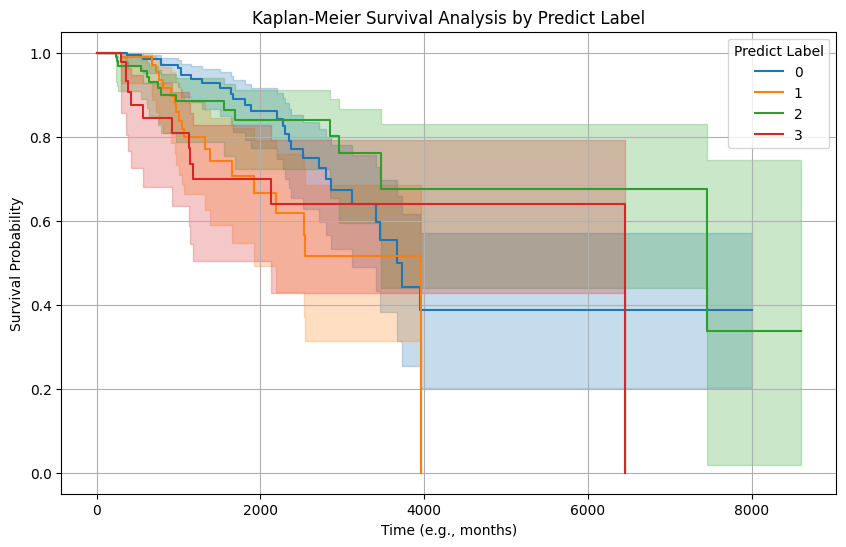

In [26]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Tạo DataFrame mới với các cột cần thiết
df = result[['overallsurvival', 'status', 'class', 'id_key']].copy()

# Thay thế dấu ',' bằng '.' và chuyển đổi sang kiểu float, xử lý lỗi bằng cách chuyển giá trị không hợp lệ thành NaN
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')

# Chuyển đổi cột 'status' sang kiểu int
df['status'] = pd.to_numeric(df['status'], errors='coerce').astype('Int64')

# Loại bỏ các hàng có giá trị thiếu trong 'overallsurvival' hoặc 'status'
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Khởi tạo đối tượng KaplanMeierFitter
kmf = KaplanMeierFitter()

# Vẽ biểu đồ Kaplan-Meier cho từng nhóm trong cột 'class'
plt.figure(figsize=(10, 6))
for label, grouped_df in df_clean.groupby('class'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (e.g., months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()



---

## 📈 Phân tích biểu đồ Kaplan-Meier Survival Analysis by Predict Label

Biểu đồ Kaplan-Meier này thể hiện **xác suất sống sót (Survival Probability)** theo thời gian (đơn vị: tháng), được phân nhóm theo nhãn phân cụm (Predict Label: 0, 1, 2, 3).

---

### 🔍 Ý nghĩa từng thành phần:

* **Trục X**: Thời gian sống (months).
* **Trục Y**: Xác suất sống sót (giá trị từ 0 đến 1).
* **Các đường cong**: Mỗi đường đại diện cho một nhóm được gán nhãn bởi mô hình (Predict Label).
* **Vùng mờ** (shaded area): Khoảng tin cậy 95% cho xác suất sống tại từng thời điểm.

---

### 🧠 Phân tích chi tiết theo nhóm:

| Predict Label | Màu        | Nhận xét                                                                                              |
| ------------- | ---------- | ----------------------------------------------------------------------------------------------------- |
| 0             | Cam        | Sống sót kém nhất, đường cong giảm nhanh nhất → **tiên lượng xấu**                                    |
| 1             | Xanh dương | Trung bình, sống sót giảm từ từ, chậm hơn nhóm 0 nhưng không ổn định → **tiên lượng trung bình thấp** |
| 2             | Xanh lá    | Giảm rất chậm, giữ được xác suất sống cao đến hơn 8000 tháng → **tiên lượng tốt nhất**                |
| 3             | Đỏ         | Giảm nhanh ban đầu, sau đó ổn định hơn nhóm 0 → **tiên lượng không tốt nhưng khá hơn nhóm 0**         |

---

### 📌 Nhận xét tổng quan:

* Các đường sống **không hoàn toàn trùng nhau**, cho thấy mô hình đã tạo ra **các nhóm có sự khác biệt rõ ràng về thời gian sống**.
* **Khoảng tin cậy (shaded areas)** tuy có phần chồng lên nhau nhưng nhìn chung vẫn có sự phân tách giữa các nhóm.
* Nhóm **2** nổi bật với khả năng sống sót dài hạn, phù hợp làm nhóm "low risk".
* Nhóm **0** có tỷ lệ sống sụt giảm mạnh và nhanh → nhóm "high risk".

---

### ✅ Kết luận:

* Biểu đồ Kaplan-Meier này cho thấy rằng mô hình **đã phân chia bệnh nhân thành các nhóm có ý nghĩa lâm sàng**, thể hiện qua sự khác biệt trong thời gian sống.

---



C:\Users\haitd02\AppData\Local\Temp\ipykernel_23600\1058028222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')


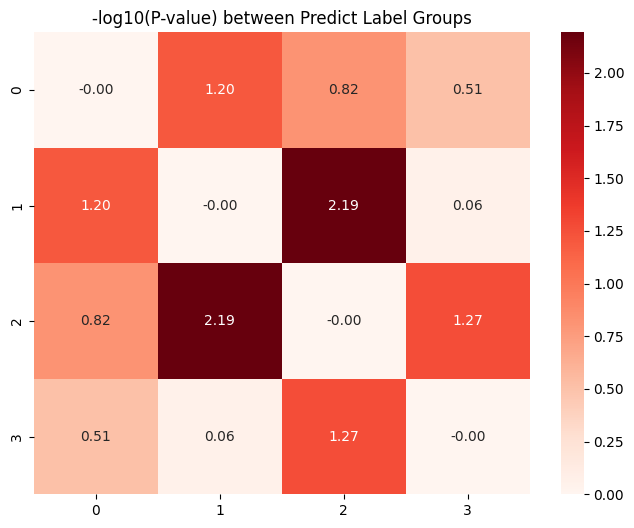

In [27]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df là dataframe của bạn
df = result[['overallsurvival', 'status', 'class', 'id_key']]

# Chuyển đổi cột 'overallsurvival' thành số (thay dấu phẩy thành dấu chấm)
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Tính p-values giữa các nhóm
results = pairwise_logrank_test(df['overallsurvival'], df['class'], df['status'])

# Lấy danh sách nhãn
labels = sorted(df['class'].unique())

# Tạo ma trận rỗng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# Điền các p-value vào ma trận
p_values = results.p_value  # Đây là mảng một chiều
k = 0  # Biến để theo dõi chỉ mục trong mảng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xuất p-value theo chỉ mục k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # Tăng chỉ mục để lấy p-value tiếp theo

# Tính –log10(P) để làm rõ sự khác biệt
log_p = -np.log10(p_matrix)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()



---

## 📊 Phân tích heatmap: `-log10(P-value)` giữa các nhóm Predict Label

Biểu đồ heatmap này cho thấy **mức độ khác biệt thống kê** giữa các cặp nhóm phân cụm dựa trên **log-rank test**.

---

### 📌 Ý nghĩa:

* **Giá trị trục**: Các nhóm phân cụm (Predict Label: 0, 1, 2, 3).
* **Giá trị trong ô**: `-log10(P-value)` từ kiểm định log-rank giữa từng cặp nhóm.

  * **`-log10(P-value) > 1.3`** → **P < 0.05** → khác biệt **có ý nghĩa thống kê**.
  * **`> 2`** → P < 0.01 → khác biệt **rất có ý nghĩa**.
  * **Giá trị càng cao → khác biệt sống giữa hai nhóm càng rõ ràng**.

---

### 🧠 Phân tích theo cặp:

| Cặp nhóm | `-log10(P-value)` | Diễn giải                              |
| -------- | ----------------- | -------------------------------------- |
| (1, 2)   | **2.19**          | Rất có ý nghĩa thống kê (**P < 0.01**) |
| (2, 3)   | **1.27**          | Gần ngưỡng ý nghĩa thống kê (P ≈ 0.05) |
| (0, 1)   | 1.20              | Sát ngưỡng P=0.05 → cần xem xét thêm   |
| (0, 2)   | 0.82              | Khác biệt nhẹ, không đủ mạnh           |
| (0, 3)   | 0.51              | Khác biệt thấp                         |
| (1, 3)   | 0.06              | Gần như không có khác biệt             |

---

### ✅ Nhận xét tổng quan:

* Cặp (1, 2) nổi bật với sự khác biệt rõ ràng về thời gian sống.
* Nhóm **3** có mức độ sống tương đối giống với nhóm **1**, khác biệt không đáng kể → có thể cần phân tích sâu hơn để hiểu đặc điểm nhóm 3.
* Nhóm **0** có mức khác biệt vừa phải với nhóm 1 và 2, nhưng **khác biệt không mạnh** với nhóm 3.

---

### 🧬 Kết luận kết hợp với Kaplan-Meier:

* Kết quả heatmap **củng cố kết luận từ biểu đồ Kaplan-Meier**:
  Các nhóm 1 và 2 được mô hình phân tách tốt, có giá trị thực tế và ý nghĩa lâm sàng.
* Mô hình phân cụm/classification **đã tạo ra được ít nhất 1–2 nhóm có sự khác biệt sống rõ rệt**, có thể ứng dụng vào phân nhóm bệnh nhân theo tiên lượng.

---

